In [21]:
# import libraries
import warnings
import itertools
import xlrd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import statsmodels.api as sm
import pickle
import math
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
np.random.seed(1)

In [22]:
def get_dataset_for_variable(variables,excel_path):
    
    month_convert={
            4:"Arp",
            5:"May",
            6:"Jun",
            7:"Jul",
            8:"Aug",
            9:"Sep",
            10:"Oct",
            11:"Nov",
            12:"Dec",
            1:"Jan",
            2:"Feb",
            3:"Mar"
        }
    workbook = xlrd.open_workbook(excel_path) #read input
    worksheet = workbook.sheet_by_index(0)

    keys={}
    keys["Month"]=[]

    #find all keys
    forbid={}
    for i in range(3,worksheet.nrows):#for each row
        forbid[i]=1
        for var in variables:
            if var.lower() in str(worksheet.cell(i,5).value).lower(): #column3 is product name and column 5 is variable
                key=str(worksheet.cell(i,5).value)+"-"+str(worksheet.cell(i,3).value)
                keys[key]=[]
                break

    j=9 #date column begin from 9 in format

    while j<worksheet.ncols:
        date3=str(xlrd.xldate.xldate_as_datetime(worksheet.cell(2,j).value,workbook.datemode))
        final_date=date3[5]+date3[6]+"-"+date3[8]+date3[9]+"-"+date3[0]+date3[1]+date3[2]+date3[3]
        ok=0
        for i in range(3,worksheet.nrows):#for each row
            bol=str(type(worksheet.cell(i,j).value))=="<class 'float'>"
            if str(worksheet.cell(i,j).value)=='x':
                forbid[i]=0
            if bol==1:
                for var in variables:
                    if var.lower() in str(worksheet.cell(i,5).value).lower():
                        key=str(worksheet.cell(i,5).value)+"-"+str(worksheet.cell(i,3).value)
                        keys[key].append(worksheet.cell(i,j).value)
                        ok=1
                        break
            elif forbid[i]:
                for var in variables:
                    if var.lower() in str(worksheet.cell(i,5).value).lower():
                        key=str(worksheet.cell(i,5).value)+"-"+str(worksheet.cell(i,3).value)
                        keys[key].append(0.0)
                        ok=1
                        break
        if ok==1:
            keys["Month"].append(final_date)
        j+=1

    #convert it to proper pandas format
    colname=[]
    leng=0
    for key in keys:
        colname.append(key)
        leng=len(keys[key])
    datarow=[]
    for w in range(0,leng):
        rw=[]
        for key in keys:
            rw.append(keys[key][w])
        rw.append(float(w))
        datarow.append(rw)
    colname.append('Index')
    dataset = pd.DataFrame(datarow,columns=colname).set_index('Index')
    return dataset

In [59]:
variables=["Leavers"]  # add variable names here
excel_path = 'PrivatizedDataforParticipants.xlsx'
forecast_period = 6 # change the forecast period here
dataset = get_dataset_for_variable(variables,excel_path)

In [60]:
dataset.set_index("Month",inplace=True)
dataset.index = pd.to_datetime(dataset.index)

In [61]:
dataset.head()

,Leavers(Norm)-Panther,Leavers(Norm)-Leopard,Leavers(Norm)-Lion
Month,,,
2016-04-01,-1.642758,-1.831229,0.0
2016-05-01,-1.425679,-1.772835,0.0
2016-06-01,-1.068171,-1.741359,0.0
2016-07-01,-1.121974,-1.536005,0.0
2016-08-01,-1.153767,-1.123777,0.0


Enter the product name(Panther/Leopard/Lion):lion


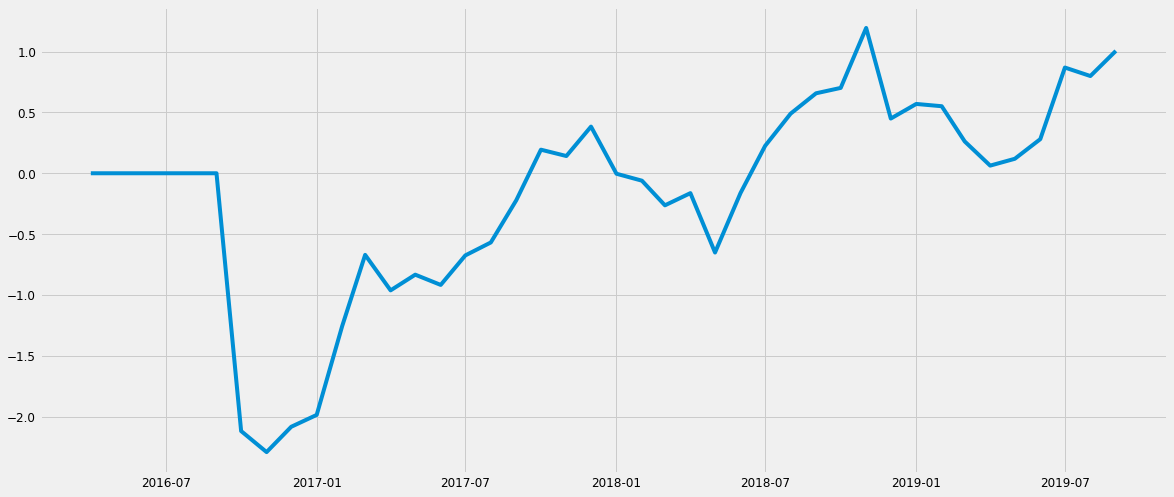

In [62]:
product_name = str(input("Enter the product name(Panther/Leopard/Lion):")).title() # enter the product name for the model
column_name='Leavers(Norm)-%s'%product_name
dataset=pd.DataFrame(dataset[column_name])
plt.plot(dataset)
plt.show()

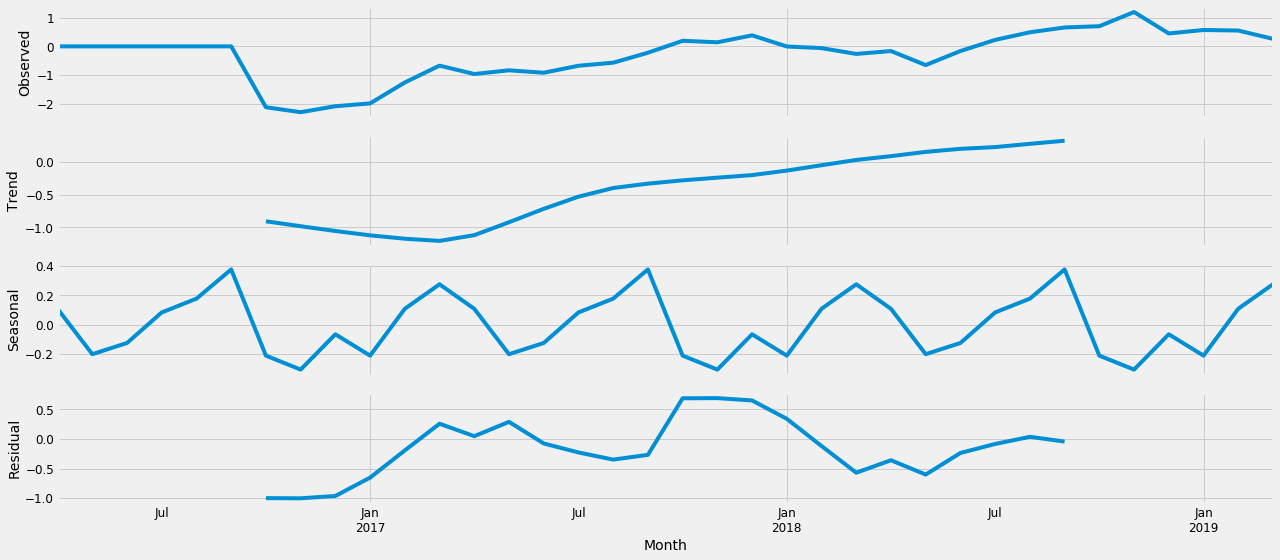

In [63]:
from pylab import rcParams
train = dataset[column_name][:-6] # using last 6 values for cross-validation
test = dataset[column_name][-6:] # using last 6 values for cross-validation
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(train, model='additive')
fig = decomposition.plot()
plt.show()

In [64]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [65]:
## finding the best parameters for sarimax
best =10**7
final_param =None
final_param_seasonal=None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if best>results.aic:
                best = results.aic
                final_param = param
                final_param_seasonal = param_seasonal
        except:
            continue

In [66]:
best,final_param,final_param_seasonal #--the lowest aic score parameters

(12.582319839699904, (1, 0, 0), (1, 0, 0, 12))

In [67]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=final_param,
                                seasonal_order=final_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(maxiter=1000)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8154      0.101      8.066      0.000       0.617       1.014
ar.S.L12      -0.1652      0.351     -0.471      0.638      -0.853       0.523
sigma2         0.0779      0.027      2.920      0.003       0.026       0.130


In [68]:
results.get_forecast(steps=forecast_period).predicted_mean.tolist() # cross validation prediction

[0.2046638809442504,
 0.25248894344622763,
 0.1450323888100398,
 0.0591227321481821,
 -0.002347886003470634,
 -0.044510719965494945]

In [69]:
test.values.tolist() # actual values from the sheet

[0.06292990576790855,
 0.11899658661292421,
 0.28031124728981244,
 0.8685195831726097,
 0.798878863807222,
 1.0052435943560698]

In [70]:
# MAPE Score calculation
def cal_mape(ypred,y):
    mape = max(0, 1 - abs(y-ypred)/abs(y))
    return mape

scores =[]
validation_forecast = results.get_forecast(steps=5)
forecast = validation_forecast.predicted_mean.tolist()
for y,ypred in zip(test.values.tolist(),forecast):
    scores.append(cal_mape(ypred,y))
print(100 * (sum(scores)/len(scores))) # MAPE Score

11.709413551522282


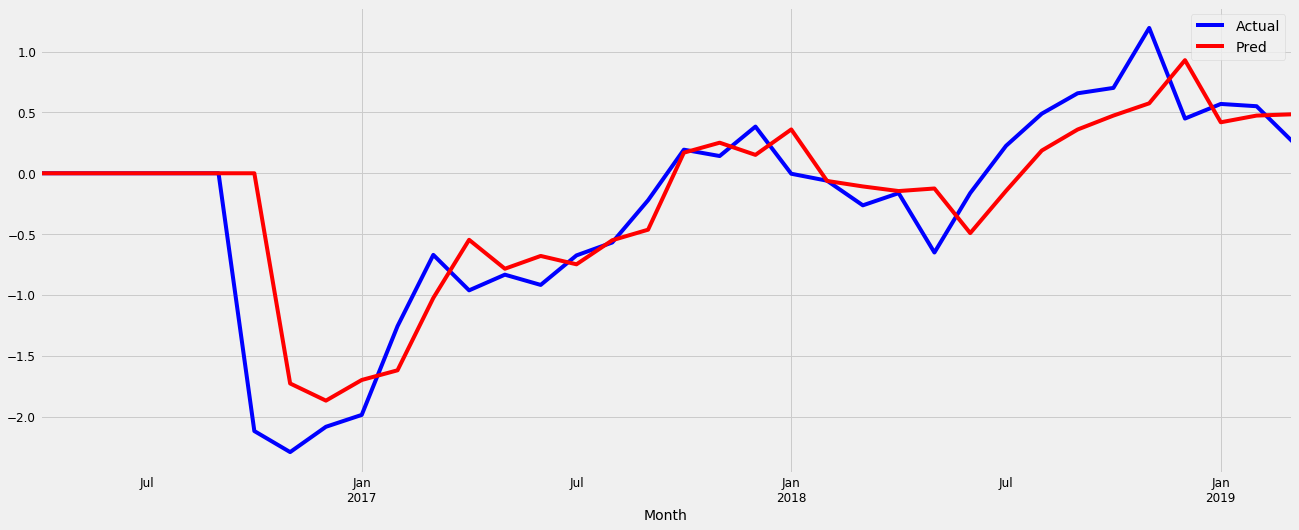

In [71]:
validation_forecast = results.predict()
predictions = pd.DataFrame(validation_forecast)
predictions.reset_index(drop=True, inplace=True)
predictions.index = train.index
predictions['Actual'] = train
predictions.rename(columns={0: 'Pred'}, inplace=True)
predictions['Actual'].plot(figsize=(20, 8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20, 8))


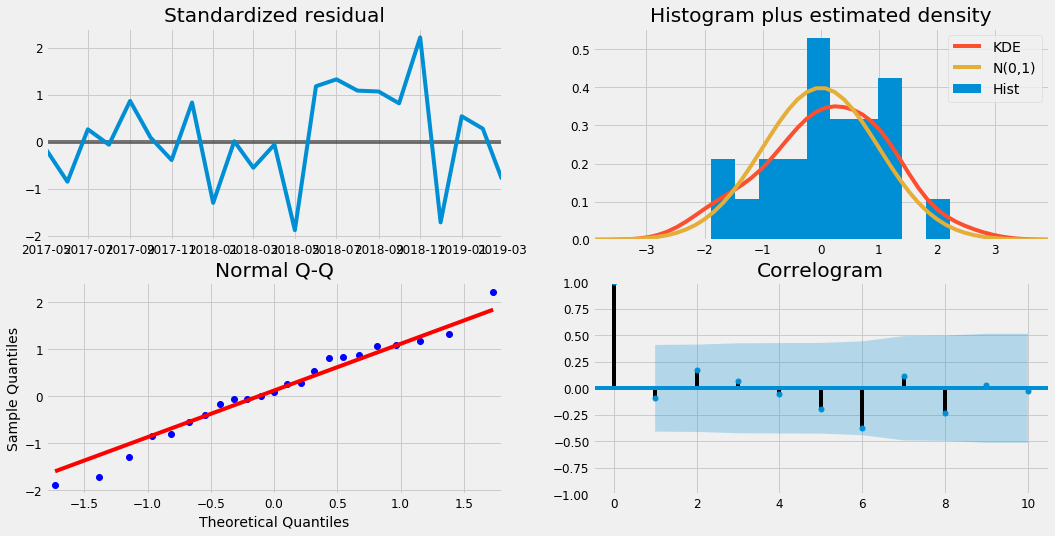

In [72]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

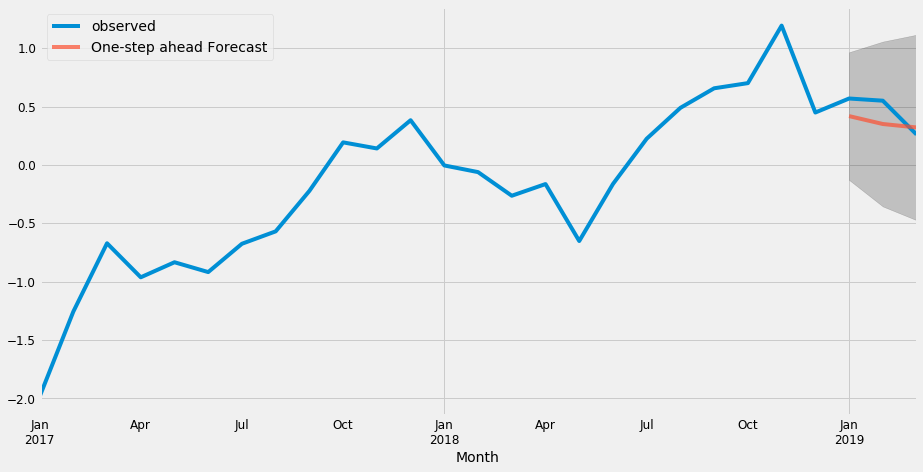

In [73]:
pred = results.get_prediction(start=pd.to_datetime('2019'), dynamic=True)
pred_ci = pred.conf_int()
ax = train['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

In [74]:
y_forecasted = pred.predicted_mean
y_truth = train['2018':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.02
The Root Mean Squared Error of our forecasts is 0.15


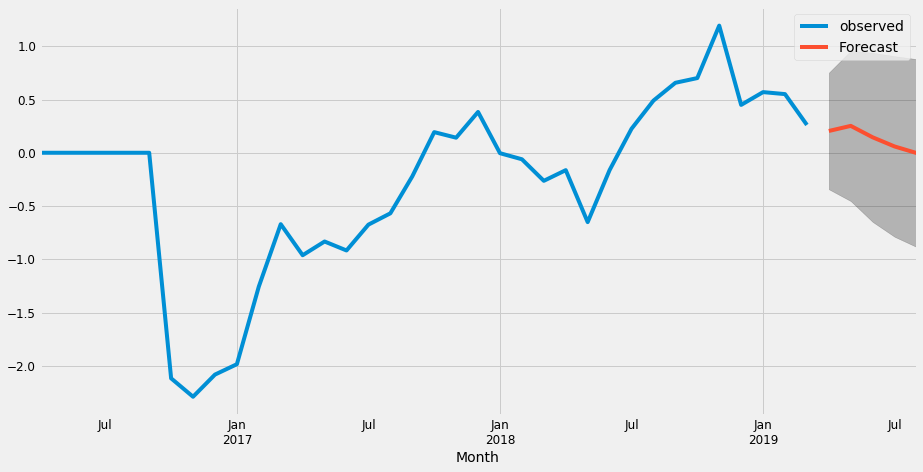

In [75]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = train.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.legend()
plt.show()

In [76]:
results.get_prediction(start=pd.to_datetime('2019-10-01'),end=pd.to_datetime('2020-03-01')).predicted_mean.tolist()

[-0.06364799314444233,
 -0.15468714364305503,
 -0.03954136755463922,
 -0.06578144012890366,
 -0.0679207297642387,
 -0.02436524878099912]

In [108]:
import os
model_path ="models"
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
model_save_path = os.path.join(model_path,column_name+".h5")
results.save(model_save_path)
